## Neural Nets

In [40]:
%matplotlib inline
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [41]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [42]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

In [43]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [60]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [45]:
#Train network with new data:
NN = Neural_Network(Lambda=0.0001)

In [46]:
#Make sure our gradients our correct after making changes:
numgrad = computeNumericalGradient(NN, trainX, trainY)
grad = NN.computeGradients(trainX, trainY)

In [47]:
#Should be less than 1e-8:
np.linalg.norm(grad-numgrad)/np.linalg.norm(grad+numgrad)

1.2192612400762927e-10

In [62]:
T = trainer(NN)

In [63]:
T.train(trainX,trainY,testX,testY)

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 88
         Function evaluations: 95
         Gradient evaluations: 95


Text(0,0.5,'Cost')

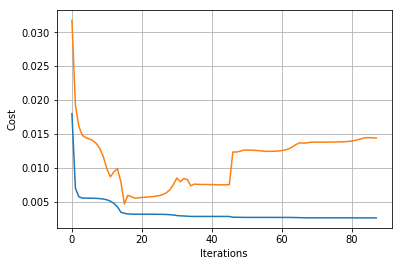

In [64]:
plt.plot(T.J)
plt.plot(T.testJ)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

### Other dataset and implementation

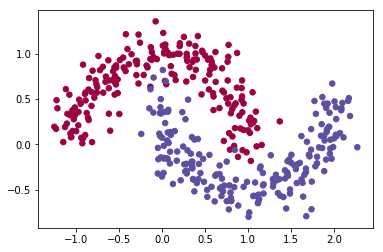

In [51]:
from sklearn import cluster, datasets, mixture
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(400, noise=0.15)
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Spectral)

In [52]:
def splitDataset(X, y, splitRatio):
    # Shuffled data
    X_copy = X.copy()
    y_copy = y.copy()
    
    np.random.shuffle(X_copy)
    np.random.shuffle(y_copy)
    
    # Training set size 
    trainSize = int((len(X_copy)-1) * splitRatio)
    
    #Split data
    trainX = X_copy[: trainSize]
    testX = X_copy[trainSize : len(X_copy)]
    
    trainY = y_copy[: trainSize]
    testY = y_copy[trainSize : len(X_copy)]
    
    return trainX, trainY, testX, testY 

In [53]:
# Split dataset
splitRatio = 0.67
trainX, trainY, testX, testY = splitDataset(X, y, splitRatio)

In [54]:
#Train network with new data:
NN = Neural_Network(Lambda=0.0001)

In [55]:
#Should be less than 1e-8:
np.linalg.norm(grad-numgrad)/np.linalg.norm(grad+numgrad)

1.2192612400762927e-10

In [56]:
T = trainer(NN)

In [57]:
T.train(trainX,trainY,testX,testY)

ValueError: shapes (267,267) and (1,3) not aligned: 267 (dim 1) != 1 (dim 0)

Text(0,0.5,'Cost')

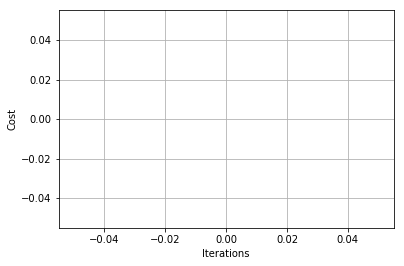

In [58]:
plt.plot(T.J)
plt.plot(T.testJ)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [65]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

In [66]:
# Gradient descent parameters (I picked these by hand)
l_rate = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [76]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [77]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss


In [78]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [88]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
        
    #i = np.arange(0, num_passes)
    #plt.plot(i, calculate_loss(model))
    #plt.xlabel('Iterations')
    #plt.ylabel('Loss')
    #plt.show()
        
    return model

In [89]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.349025
Loss after iteration 10000: 0.035290


Text(0.5,1,'Decision Boundary for hidden layer size 3')

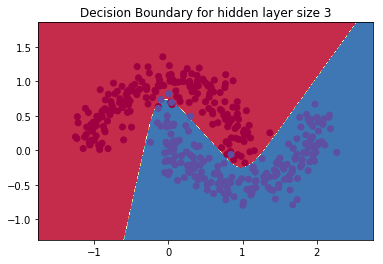

In [81]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

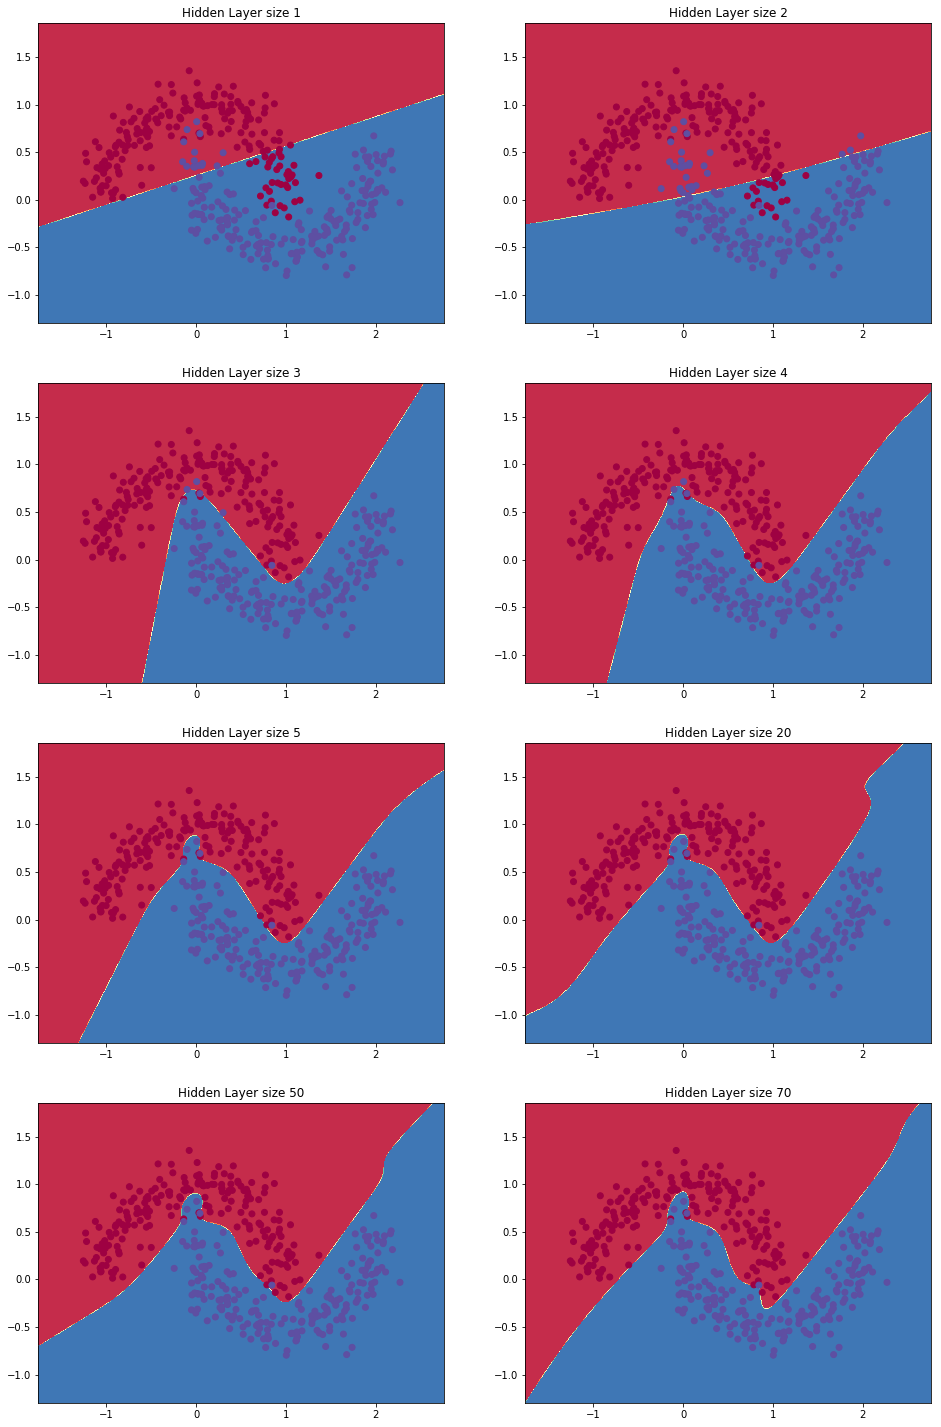

In [90]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50, 70]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()